In [2]:
import hoomd
import hoomd.md
import numpy
import math

HOOMD-blue v2.1.3 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 02/07/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----


# Logging quantities to a file

## The logger

HOOMD can log a variety of quantities to a text file during the run. Start with the Lennard-Jones tutorial script:

In [3]:
hoomd.context.initialize('--mode=cpu')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5)
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
all = hoomd.group.all();
hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.langevin(group=all, kT=1.0, seed=987)

HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 125 particles
notice(2): integrate.langevin/bd is using specified gamma values


``analyze.log`` writes a text file. It combines data values from many different sources into a single text file with named columns. Let's log the simulation wall clock time, potential energy, and kinetic temperature. Forcing `overwrite=True` will overwrite any existing log so that this notebook can be rerun with changing parameters. In a restartable job, you would want the default behavior to append to an existing log file.

In [4]:
log1 = hoomd.analyze.log(filename="log-output.log", quantities=['time', 'potential_energy', 'temperature'], period=100, overwrite=True)

`analyze.log` enables the Log analyzer. Subsequent `run` commands will trigger the logger to run every `period` time steps.

In [5]:
hoomd.run(10000, quiet=True)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no


In [6]:
!head log-output.log

timestep	time	potential_energy	temperature
0	4.247098	-28.91921997	0
100	4.780137	-29.0405998	0.1749385115
200	4.784903	-29.70963323	0.3439715877
300	4.790023	-31.33924376	0.4612062131
400	4.795108	-35.39667407	0.5617574686
500	4.800145	-41.54134445	0.6895929566
600	4.8051	-47.9447567	0.727039448
700	4.810012	-57.66329761	0.8083082521
800	4.814891	-62.28206358	0.869871967


As you can see, `analyze.log` writes a simple delimited text file. You can import this with numpy to plot columns.

In [7]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)

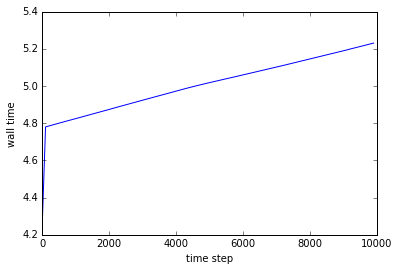

In [8]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(data[:,0], data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('wall time')

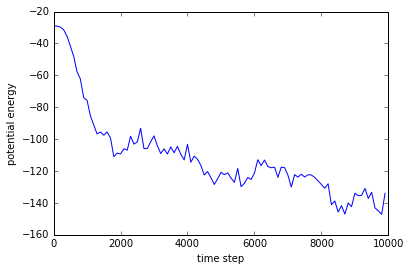

In [9]:
pyplot.plot(data[:,0], data[:,2])
pyplot.xlabel('time step')
pyplot.ylabel('potential energy')

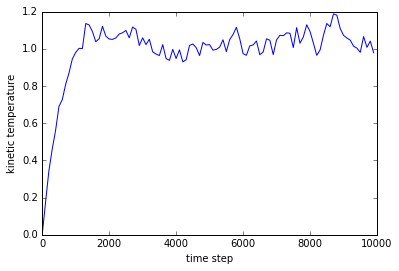

In [10]:
pyplot.plot(data[:,0], data[:,3])
pyplot.xlabel('time step')
pyplot.ylabel('kinetic temperature')

You can query the value most recently logged to the file for use in your python script.

In [11]:
log1.query('time')

5.230798

In [12]:
log1.query('potential_energy')

-133.981397004506

In [13]:
log1.query('temperature')

0.9785849721298574

You can disable a logger so that it does not execute in subsequent runs.

In [14]:
log1.disable()

## Custom quantities

You can register an arbitrary python callable as a logger quantity.

In [15]:
log2 = hoomd.analyze.log(filename="log2-output.log", quantities=['p1x', 'cosp1x', 'sum'], period=100, overwrite=True)
log2.register_callback('p1x', lambda timestep: system.particles[1].position[0])

A custom quantity may query other log quantities. However, the queried quantity must be listed earlier in the quantities list. Log quantities are evaluated from left to right.

In [16]:
log2.register_callback('cosp1x', lambda timestep: math.cos(log2.query('p1x')))

If you want to maintain internal state within your callback, use a python class.

In [17]:
class my_sum:
    def __init__(self, logger):
        self.total = 0;
        self.logger = logger;
        
    def __call__(self, timestep):
        self.total += self.logger.query('cosp1x')
        return self.total

s = my_sum(log2);
log2.register_callback('sum', s)

In [18]:
hoomd.run(10000, quiet=True)

In [19]:
!head log2-output.log

timestep	p1x	cosp1x	sum
10000	1.966974457	-0.3858953321	-0.3858953321
10100	2.060398832	-0.4702751287	-0.8561704608
10200	2.136605594	-0.5360991381	-1.392269599
10300	2.27159822	-0.6448308017	-2.037100401
10400	2.440058704	-0.7638530902	-2.800953491
10500	2.636575917	-0.8751663771	-3.676119868
10600	2.808832018	-0.9451441751	-4.621264043
10700	2.844850138	-0.9562940714	-5.577558114
10800	2.903288173	-0.9717396079	-6.549297722


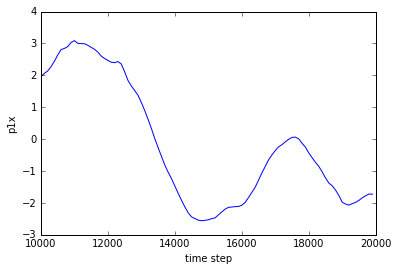

In [20]:
data = numpy.genfromtxt(fname='log2-output.log', skip_header=True)
pyplot.plot(data[:,0], data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('p1x')

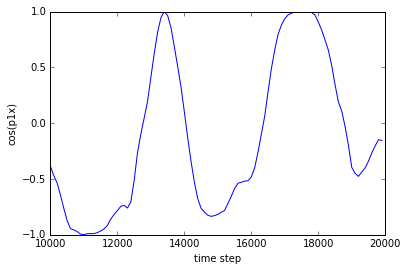

In [21]:
pyplot.plot(data[:,0], data[:,2])
pyplot.xlabel('time step')
pyplot.ylabel('cos(p1x)')

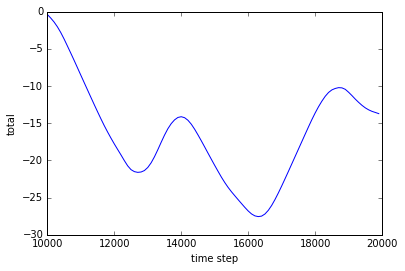

In [22]:
pyplot.plot(data[:,0], data[:,3])
pyplot.xlabel('time step')
pyplot.ylabel('total')

## Query only logger

If you specify `None` as the file name, the logger operates but does not write output to the file. Use this mode if you want to query logged quantities in your python script but do not wish to save those quantities in a file.

In [23]:
log3 = hoomd.analyze.log(filename=None, quantities=['time', 'potential_energy', 'temperature'], period=1)

In [24]:
hoomd.run(10000, quiet=True)

In [25]:
log3.query('potential_energy')

-147.42262324725888